In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline

# 1 - Load Fashion MNIST 

In [2]:
# put the original *.gz files under 'your ipython notework location/data/fashion/'
# Otherwise it'll download MNIST instead!
fashion_mnist = input_data.read_data_sets('data/fashion', one_hot=True)

Extracting data/fashion/train-images-idx3-ubyte.gz
Extracting data/fashion/train-labels-idx1-ubyte.gz
Extracting data/fashion/t10k-images-idx3-ubyte.gz
Extracting data/fashion/t10k-labels-idx1-ubyte.gz


# 2 - Convolutional Neural Networks 

In [28]:
#Use He initialization 
def weight_initialization(shape):
    if len(shape) == 4:
        stride = shape[0]
        n_input = shape[2]
        sd = math.sqrt(2.0/ (n_input * stride * stride))
        
    elif len(shape) == 2:
        n_in = shape[0] 
        sd = math.sqrt(2.0/ n_in)
        
    initial = tf.truncated_normal(shape, stddev=sd)
    return tf.Variable(initial)

#def weight_initialization(shape):
#    initial = tf.truncated_normal(shape, stddev=0.1)
#    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.0, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [7]:
def create_placeholders():
    x = tf.placeholder(tf.float32, shape=[None, 784])
    y_ = tf.placeholder(tf.float32, shape=[None, 10])
    keep_prob = tf.placeholder(tf.float32)
    return x, y_, keep_prob
    
def forward_cost(x, y_, keep_prob):
    x_image = tf.reshape(x, [-1, 28, 28, 1])
    #conv then pool
    W_conv1 = weight_initialization([5, 5, 1, 32])
    b_conv1 = bias_variable([32])
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)
    #conv then pool
    W_conv2 = weight_initialization([5, 5, 32, 64])
    b_conv2 = bias_variable([64])
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)
    #regular layer with dropout
    W_fc1 = weight_initialization([7 * 7 * 64, 1024])
    b_fc1 = bias_variable([1024])
    h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
    #regular layer
    W_fc2 = weight_initialization([1024, 10])
    b_fc2 = bias_variable([10])
    ZL = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
    #compute cost
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=ZL))
    return ZL, cost


In [17]:
x, y_, keep_prob = create_placeholders()
learning_rate = tf.placeholder(tf.float32)
ZL, cost = forward_cost(x, y_, keep_prob)
#optimizer = tf.train.AdamOptimizer(learning_rate = 0.001).minimize(cost)
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
correct_prediction = tf.equal(tf.argmax(ZL,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## random initialization

learning rate = 5.0E-03
step 0, training accuracy 0.400
step 10, training accuracy 0.460
step 20, training accuracy 0.640
step 30, training accuracy 0.760
step 40, training accuracy 0.700
step 50, training accuracy 0.740
step 60, training accuracy 0.800
step 70, training accuracy 0.720
step 80, training accuracy 0.740
step 90, training accuracy 0.800
test accuracy 0.753
---------------------
learning rate = 1.0E-03
step 0, training accuracy 0.180
step 10, training accuracy 0.620
step 20, training accuracy 0.740
step 30, training accuracy 0.800
step 40, training accuracy 0.860
step 50, training accuracy 0.760
step 60, training accuracy 0.820
step 70, training accuracy 0.800
step 80, training accuracy 0.840
step 90, training accuracy 0.840
test accuracy 0.822
---------------------
learning rate = 5.0E-04
step 0, training accuracy 0.260
step 10, training accuracy 0.580
step 20, training accuracy 0.660
step 30, training accuracy 0.700
step 40, training accuracy 0.600
step 50, training accu

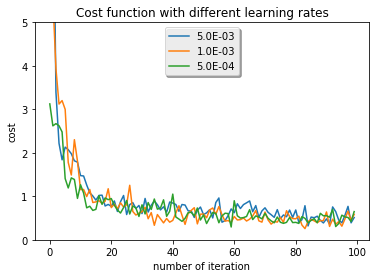

In [22]:
costs = []
learning_rates = [5*0.001, 0.001, 5*0.0001]

t= time.time() 

for rate in learning_rates:
    print('learning rate = %.1E' %rate)
    costs = []
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(100):
            batch = fashion_mnist.train.next_batch(50)
            optimizer.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.8, learning_rate: rate})
            costs.append(cost.eval(feed_dict={x: batch[0], y_: batch[1], keep_prob: 1.0}))
            if i % 10 == 0:
                train_accuracy = accuracy.eval(feed_dict={x: batch[0], y_: batch[1], keep_prob: 1.0})
                print('step %d, training accuracy %.3f' % (i, train_accuracy))


        print('test accuracy %.3f' % accuracy.eval(feed_dict={x: fashion_mnist.test.images, y_: fashion_mnist.test.labels, keep_prob: 1.0}))
    
    plt.plot(costs, label = '%.1E' %rate)
    print('---------------------')

t= time.time() -t
print('time elapsed', t)  
    
    
plt.ylabel('cost')
plt.xlabel('number of iteration')
plt.title("Cost function with different learning rates" )
legend = plt.legend(loc='upper center', shadow=True)
axes = plt.gca()
axes.set_ylim([0,5])
plt.show()

Learning rate 0.001 gives faster drop of loss function at the early stage. So we will use this rate in the final run

## He initialization

learning rate = 1.0E-03
step 0, training accuracy 0.400
step 10, training accuracy 0.640
step 20, training accuracy 0.820
step 30, training accuracy 0.760
step 40, training accuracy 0.820
step 50, training accuracy 0.780
step 60, training accuracy 0.900
step 70, training accuracy 0.760
step 80, training accuracy 0.840
step 90, training accuracy 0.860
test accuracy 0.827
---------------------
time elapsed 51.78612995147705


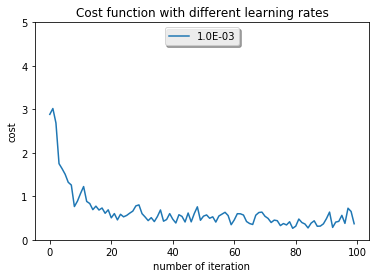

In [24]:
costs = []
learning_rates = [0.001]

t= time.time() 

for rate in learning_rates:
    print('learning rate = %.1E' %rate)
    costs = []
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(100):
            batch = fashion_mnist.train.next_batch(50)
            optimizer.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.8, learning_rate: rate})
            costs.append(cost.eval(feed_dict={x: batch[0], y_: batch[1], keep_prob: 1.0}))
            if i % 10 == 0:
                train_accuracy = accuracy.eval(feed_dict={x: batch[0], y_: batch[1], keep_prob: 1.0})
                print('step %d, training accuracy %.3f' % (i, train_accuracy))


        print('test accuracy %.3f' % accuracy.eval(feed_dict={x: fashion_mnist.test.images, y_: fashion_mnist.test.labels, keep_prob: 1.0}))
    
    plt.plot(costs, label = '%.1E' %rate)
    print('---------------------')

t= time.time() -t
print('time elapsed', t)  
    
    
plt.ylabel('cost')
plt.xlabel('number of iteration')
plt.title("Cost function with different learning rates" )
legend = plt.legend(loc='upper center', shadow=True)
axes = plt.gca()
axes.set_ylim([0,5])
plt.show()

He initialization gives a better starting loss function value at the beginning, so we'll use He initialization in the final run.

In [58]:
costs = []
learning_rates = [0.001]

t= time.time() 

for rate in learning_rates:
    print('learning rate = %.1E' %rate)
    costs = []
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(10000):
            batch = fashion_mnist.train.next_batch(50)
            optimizer.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.8, learning_rate: rate})
            if i % 1000 == 0:
                train_accuracy = accuracy.eval(feed_dict={x: batch[0], y_: batch[1], keep_prob: 1.0})
                print('step %d, training accuracy %.3f' % (i, train_accuracy))

        conf = tf.confusion_matrix(tf.argmax(y_,1),tf.argmax(ZL,1))
        conf_mat = conf.eval(feed_dict={x: fashion_mnist.test.images, y_: fashion_mnist.test.labels, keep_prob: 1.0})
        print('test accuracy %.3f' % accuracy.eval(feed_dict={x: fashion_mnist.test.images, y_: fashion_mnist.test.labels, keep_prob: 1.0}))
    
    print('---------------------')

t= time.time() -t
print('time elapsed', t)  
    


learning rate = 1.0E-03
step 0, training accuracy 0.300
step 1000, training accuracy 0.880
step 2000, training accuracy 0.860
step 3000, training accuracy 0.980
step 4000, training accuracy 0.940
step 5000, training accuracy 0.960
step 6000, training accuracy 0.980
step 7000, training accuracy 1.000
step 8000, training accuracy 0.900
step 9000, training accuracy 1.000
test accuracy 0.913
---------------------
time elapsed 1902.602212190628


## Confusion Matrix

Confusion matrix


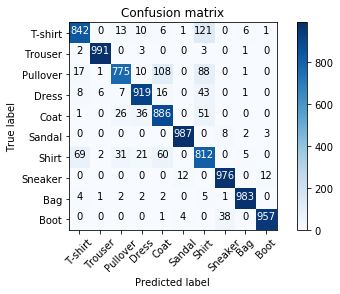

In [64]:
class_names = np.array(['T-shirt', 'Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Boot'])
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(conf_mat, classes=class_names,
                      title='Confusion matrix')

plt.show()

The biggest error occurs when shirt, T-shirt, coat and pullover are misidentified. This is as expected since they looks very alike. To speed up the runing time, one can consider working on a subset of the entire dataset, which includes shirt, t-shirt, coat and pullover and work out a better algorithm. 

## It achieves 91.7% test accuaracy quickly! Next step is using ResNet to get even better accuracy.